In [1]:
from helpers import math_helper
from sensors.activpal import *
from utils import read_functions
from scipy import signal
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import tree
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

import pandas as pd
import numpy as np
import statistics
import os
import pickle
import matplotlib.pyplot as plt

Adnan Akbas
# Feature Extraction

In [2]:
activpal = Activpal()

features_columns = ['standard_deviation_x', 'mean_x', 'standard_deviation_y', 'mean_y','standard_deviation_z', 'mean_z', 'activiteit']
activity_columns = ['activity_cycling_light', 'activity_cycling_heavy', 'activity_walking', 'activity_running', 'activity_standing', 'activity_sitten']
activities = ['fietsen licht', 'fietsen zwaar', 'lopen', 'rennen', 'staan', 'zitten']

test_users = ['BMR004', 'BMR034', 'BMR097']

# src: https://dbader.org/blog/python-memoization#:~:text=In%20Python%2C%20using%20a%20key,the%20cached%20result%20is%20returned.
def memoize(func):
    cache = dict()

    def memoized_func(*args):
        if args in cache:
            return cache[args]
        result = func(*args)
        cache[args] = result
        return result

    return memoized_func


activpal_read_data = memoize(activpal.read_data)

In [3]:
def extract_features_from_correspondent(correspondent, segment_size=6.4):
    features_df = pd.DataFrame(columns=features_columns, index=pd.to_datetime([]))

    # Getting dataset for a correspodent
    activities_df = read_functions.read_activities(correspondent)

    for activity_name in activities:
        activity = activities_df.loc[activity_name]
        if not activity.empty:
            start_time = activity.start
            stop_time = activity.stop
            activpal_df = activpal_read_data(correspondent, start_time, stop_time)

            # denormalizing dataset
            activpal_df['x'] = math_helper.convert_value_to_g(activpal_df['pal_accX'])
            activpal_df['y'] = math_helper.convert_value_to_g(activpal_df['pal_accY'])
            activpal_df['z'] = math_helper.convert_value_to_g(activpal_df['pal_accZ'])

            date_range = pd.date_range(start_time, stop_time, freq=str(segment_size) + 'S')
            
            for time in date_range:
                segment_time = time + pd.DateOffset(seconds=segment_size)
                activpal_segment = activpal_df[(activpal_df.index >= time) & (activpal_df.index < segment_time)]

                stdev_x =  statistics.stdev(activpal_segment['x']) if len(activpal_segment['x']) >= 2 else 0
                mean_x = activpal_segment['x'].mean()

                stdev_y =  statistics.stdev(activpal_segment['y']) if len(activpal_segment['y']) >= 2 else 0
                mean_y = activpal_segment['y'].mean()

                stdev_z =  statistics.stdev(activpal_segment['z']) if len(activpal_segment['z']) >= 2 else 0
                mean_z = activpal_segment['z'].mean()  


                features_df.loc[segment_time] = [stdev_x, mean_x, stdev_y, mean_y, stdev_z, mean_z, activity_name]

    return features_df


def extract_features_from_correspondents(correspodents,  segment_size=6.4):
    all_features_df = pd.DataFrame(index=pd.to_datetime([]))

    print("starting extraction of segment_size: ", segment_size)
    for correspodent in correspodents:        
        features_df     = extract_features_from_correspondent(correspodent, segment_size)
        all_features_df = pd.concat([all_features_df, features_df])
    
    print("Ended extraction")

    return all_features_df

def extract_features_from_all_correspondents(exclude_test_correspodent = True,  segment_size=6.4):
    
    exclude_directory = ['output', 'throughput', 'Test data','.ipynb_checkpoints']
    exclude_respodents = ['BMR015','BMR025','BMR027', 'BMR035', 'BMR051', 'BMR054', 'BMR060', 'BMR099', 'BMR100']
    
    exclude = exclude_respodents + exclude_directory
    
    if (exclude_test_correspodent):
        exclude = exclude + test_users
    
    correspodents = []
    
    for directory in os.walk('../../data'):
        if directory[0] == '../../data':
            correspodents = directory[1]
            
    for exclude_item in exclude:
        if exclude_item in correspodents:
            correspodents.remove(exclude_item)    
        
    return extract_features_from_correspondents(correspodents, segment_size)

In [4]:
def get_model_scores_on_segment_size(segment_size):
    test_dataset = extract_features_from_all_correspondents(True, segment_size)

    test_dataset[activity_columns] = 0

    test_dataset.loc[(test_dataset['activiteit'] == 'lopen'), 'activity_walking'] = 1
    test_dataset.loc[(test_dataset['activiteit'] == 'rennen'), 'activity_running'] = 1
    test_dataset.loc[(test_dataset['activiteit'] == 'staan'), 'activity_standing'] = 1
    test_dataset.loc[(test_dataset['activiteit'] == 'zitten'), 'activity_sitten'] = 1
    test_dataset.loc[(test_dataset['activiteit'] == 'fietsen licht'), 'activity_cycling_light'] = 1
    test_dataset.loc[(test_dataset['activiteit'] == 'fietsen zwaar'), 'activity_cycling_heavy'] = 1

    test_dataset.drop('activiteit', axis=1, inplace=True)
    test_dataset.dropna(how='any', inplace=True)

    x = test_dataset[features_columns[:-1]]
    y = test_dataset[activity_columns]

    train_x, valid_x, train_y, valid_y = train_test_split(x,y, test_size=0.2, random_state=0)

    
    #### Quick analysis
    accuracy_scores = []

    n_estimator_numbers = range(10,200,1)
    print(n_estimator_numbers)

    for i in n_estimator_numbers:
       # rfc_t = RandomForestClassifier(n_estimators=i, random_state=0)
       # rfc_t.fit(train_x, train_y)

       # predictions = rfc_t.predict(valid_x)
        accuracy_scores.append( cross_val_score( RandomForestClassifier(n_estimators=i, random_state=0), x, y, cv=5, scoring='accuracy').mean())
        accuracy_scores.append(accuracy_score(valid_y, predictions, normalize=True))

    np_accuracy_scores = np.array(accuracy_scores)
    number_of_trees = np.argmax(np_accuracy_scores)  + 10

        

    
    # validation dataset
    ftc = RandomForestClassifier(n_estimators=number_of_trees, random_state=0)
    ftc.fit(train_x, train_y)

    prediction_y = ftc.predict(valid_x)

    accuracy = accuracy_score(valid_y, prediction_y)
    precision = precision_score(valid_y, prediction_y, average='micro')
    recall = recall_score(valid_y, prediction_y, average='micro')

    #cross validation
    cross_val_accuracy_scores = cross_val_score(RandomForestClassifier(n_estimators=number_of_trees, random_state=0), x, y, scoring='accuracy')
    cross_val_precision_scores = cross_val_score(RandomForestClassifier(n_estimators=number_of_trees, random_state=0), x, y , scoring='precision_micro')
    cross_val_recall_scores = cross_val_score(RandomForestClassifier(n_estimators=number_of_trees, random_state=0), x, y , scoring='recall_micro')

    return [number_of_trees, accuracy , precision, recall, cross_val_accuracy_scores.mean(), cross_val_precision_scores.mean(), cross_val_recall_scores.mean()]


In [5]:
def plot_stuff(df):
    df.plot(y=['accuracy', 'precision', 'recall'], marker='o', ylabel='scores', xlabel='segment size(seconds)', title= 'validation dataset')
    df.plot(y=['cross_val_accuracy', 'cross_val_precision', 'cross_val_recall'], marker='o',  ylabel='scores',xlabel='segment size(seconds)', title = 'cross validation')

In [6]:
## tAdd

In [15]:
score_columns = ['number_of_trees', 'accuracy', 'precision', 'recall', 'cross_val_accuracy',  'cross_val_precision',  'cross_val_recall']
results_with_trees = pd.DataFrame(columns=score_columns)
segment_sizes = np.arange(6.0, 14.0, 0.1)

for segment_size in segment_sizes:
    results_with_trees.loc[segment_size] = get_model_scores_on_segment_size(round(segment_size, 1))

starting extraction of segment_size:  6.0
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.1
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.2
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.3
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.4
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.5
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.6
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.7
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.8
Ended extraction
range(10, 200)
starting extraction of segment_size:  6.9
Ended extraction
range(10, 200)
starting extraction of segment_size:  7.0
Ended extraction
range(10, 200)
starting extraction of segment_size:  7.1
Ended extraction
range(10, 200)
starting extraction of segment_size:  7.2
Ended extraction
range(10, 200)
starting extraction of segment_size:  

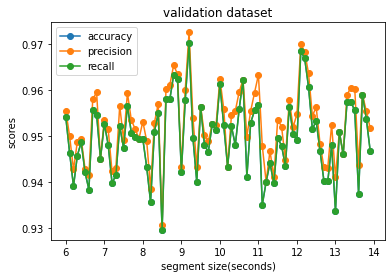

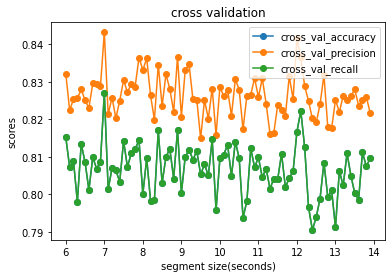

In [16]:
plot_stuff(results_with_trees)

In [17]:
results_with_trees['number_of_trees'] = results_with_trees['number_of_trees'] + 10

In [18]:
results_with_trees.sort_values(by=['accuracy'],ascending=False , inplace=True)
results_with_trees.head(5)

,number_of_trees,accuracy,precision,recall,cross_val_accuracy,cross_val_precision,cross_val_recall
9.2,73.0,0.970252,0.972477,0.970252,0.811899,0.834658,0.811899
12.1,93.0,0.968373,0.969834,0.968373,0.822249,0.836513,0.822249
12.2,99.0,0.966817,0.968278,0.966817,0.812574,0.828898,0.812574
8.8,71.0,0.963243,0.965330,0.963243,0.804206,0.822045,0.804206
8.9,171.0,0.962306,0.963374,0.962306,0.817187,0.836683,0.817187


In [19]:
results_with_trees.sort_values(by=['cross_val_accuracy'],ascending=False , inplace=True)
results_with_trees.head(5)

,number_of_trees,accuracy,precision,recall,cross_val_accuracy,cross_val_precision,cross_val_recall
7.0,203.0,0.952673,0.953509,0.952673,0.827059,0.843252,0.827059
12.1,93.0,0.968373,0.969834,0.968373,0.822249,0.836513,0.822249
8.9,171.0,0.962306,0.963374,0.962306,0.817187,0.836683,0.817187
8.4,141.0,0.954974,0.956978,0.954974,0.817032,0.834617,0.817032
12.0,21.0,0.949025,0.954751,0.949025,0.816752,0.841591,0.816752


It's better to look cross validatio score because it's better representation whaat model does when it's sees something it doesn't recognize. Looking at the results i decided that it's better to take 1 small, 1 medium and one large time segment with somedistance between them.

Seconds : number of trees

7.0  : 203

12.1 : 93

8.9  : 171

In [ ]:
## Normal

In [ ]:
score_columns = ['accuracy', 'precision', 'recall', 'cross_val_accuracy',  'cross_val_precision',  'cross_val_recall']
results = pd.DataFrame(columns=score_columns)
segment_sizes = np.arange(1.0, 14.0, 0.1)

for segment_size in segment_sizes:
    results.loc[segment_size] = get_model_scores_on_segment_size(round(segment_size, 1))

In [ ]:
plot_stuff(results)

In [ ]:
results[results.cross_val_accuracy.max() == results.cross_val_accuracy]

In [ ]:
results.sort_values(by=['accuracy'],ascending=False , inplace=True)
results.head()

In [ ]:
results.sort_values(by=['cross_val_accuracy'],ascending=False , inplace=True)
results.head()